In [1]:
%cd ..

/home/work/AnacondaProjects/categorical_bpl


In [2]:
import argparse
import collections
import random
import pyro
import torch
import matplotlib.pyplot as plt
import numpy as np
import data_loader.data_loaders as module_data
import model.model as module_arch
from parse_config import ConfigParser
from trainer import Trainer

In [3]:
%matplotlib inline

In [4]:
torch.autograd.set_detect_anomaly(True)

In [5]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

In [6]:
Args = collections.namedtuple('Args', 'config resume device')
config = ConfigParser.from_args(Args(config='omniglot_config.json', resume=None, device=None))

In [7]:
logger = config.get_logger('train')

In [8]:
# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

Files already downloaded and verified


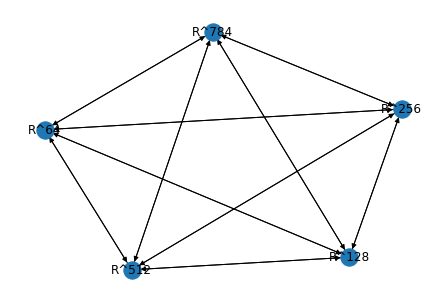

In [9]:
# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
model.draw()

In [10]:
model.resume_from_checkpoint('saved/models/Omniglot_VaeCategory/0427_093817/model_best.pth')
model.eval()

VAECategoryModel(
  (prior_0): StandardNormal()
  (prior_1): StandardNormal()
  (prior_2): StandardNormal()
  (prior_3): StandardNormal()
  (prior_4): StandardNormal()
  (likelihood_0): PathDensityNet(
    (layer_0): Sequential(
      (0): Linear(in_features=64, out_features=456, bias=True)
      (1): BatchNorm1d(456, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=456, out_features=784, bias=True)
    )
    (distribution): BernoulliObservation()
  )
  (likelihood_1): PathDensityNet(
    (layer_0): Sequential(
      (0): Linear(in_features=256, out_features=648, bias=True)
      (1): BatchNorm1d(648, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=648, out_features=784, bias=True)
    )
    (distribution): BernoulliObservation()
  )
  (likelihood_2): PathDensityNet(
    (layer_0): Sequential(
      (0): Linear(in_features=128, out_features=520, bias=True)
    

In [11]:
validation_data = random.choice(list(valid_data_loader))[0]

In [12]:
prediction_data = model(observations=validation_data)

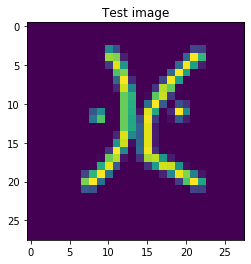

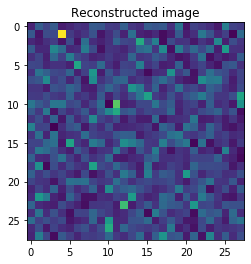

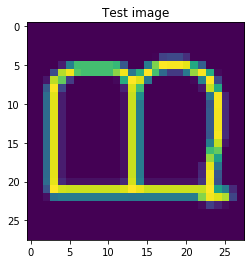

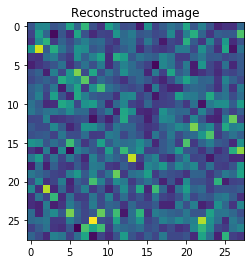

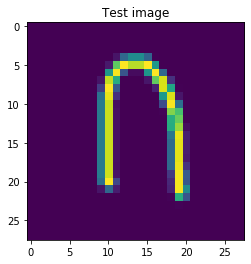

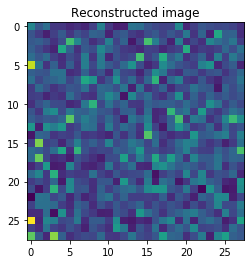

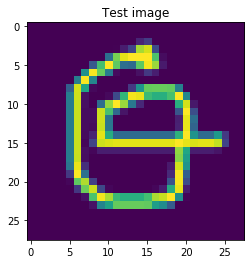

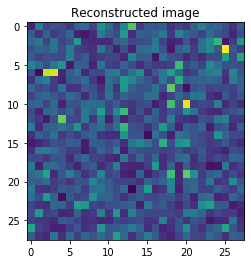

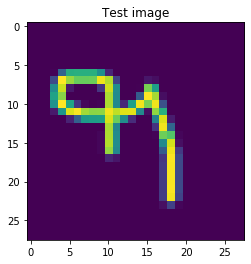

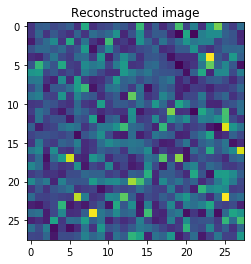

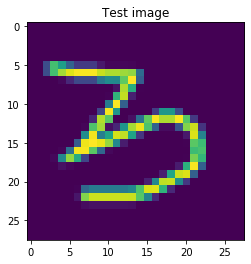

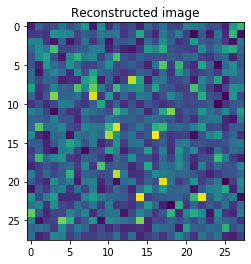

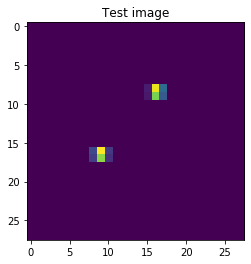

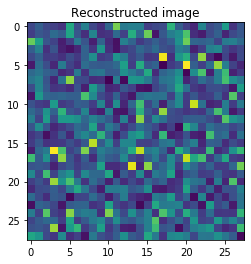

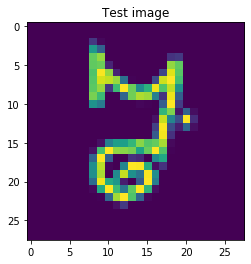

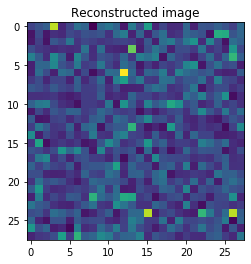

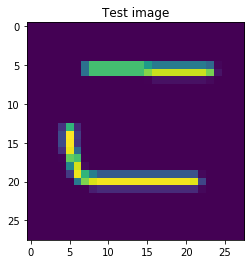

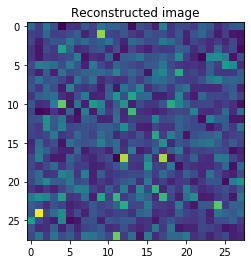

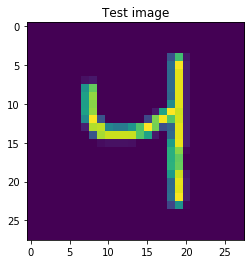

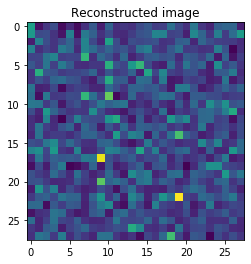

In [13]:
for k in np.random.randint(0, validation_data.shape[0], 10):
    image = validation_data[k].view(28, 28).detach().cpu().numpy()
    plt.title('Test image')
    plt.imshow(image)
    plt.show()

    prediction = prediction_data[k].view(28, 28).detach().cpu().numpy()
    plt.title('Reconstructed image')
    plt.imshow(prediction)
    plt.show()

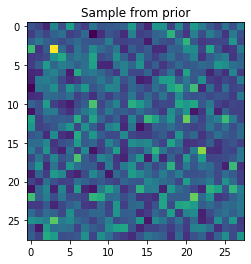

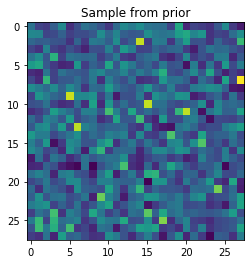

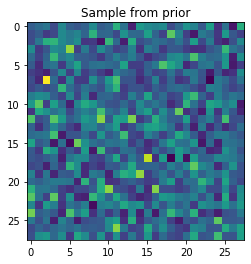

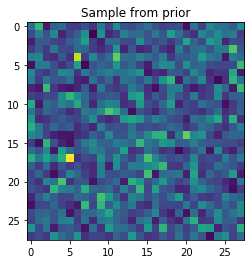

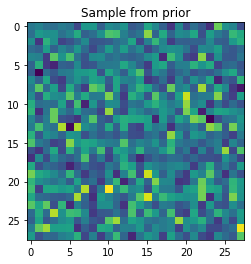

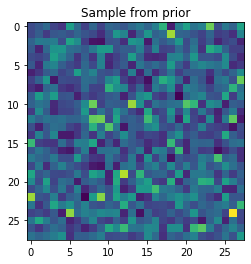

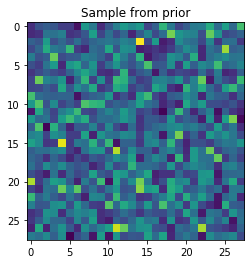

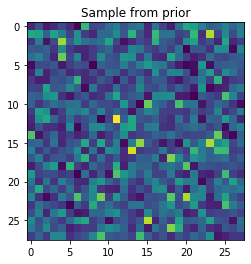

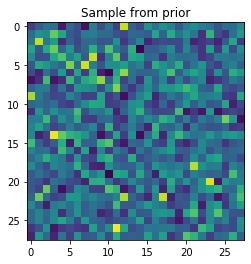

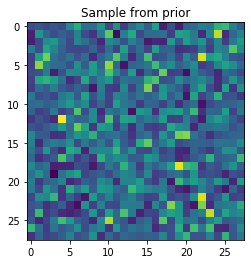

In [14]:
for k in range(10):
    sample = model(None).view(28, 28).detach().cpu().numpy()
    plt.title('Sample from prior')
    plt.imshow(sample)
    plt.show()